In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import statistics
from sklearn.metrics import roc_curve, auc, mean_squared_error
import pickle
from collections import Counter
from math import sqrt

In [3]:
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise import SVD
from surprise.prediction_algorithms import knns
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import KFold
from surprise.prediction_algorithms import matrix_factorization

# 1: Sparsity

In [4]:
#Load Data
df = pd.read_csv('data/ml-latest-small/ratings.csv')

In [5]:
# sparsity = total available/total possible
no_users = len(df['userId'].unique())
no_movies = len(df['movieId'].unique())
sparsity = 1 - (len(df) / (no_users * no_movies))
print('----------Report-------------')
print('Sparsity is:', sparsity)
print('-----------------------------')

----------Report-------------
Sparsity is: 0.9835608583913366
-----------------------------


# 2: Frequency Histogram

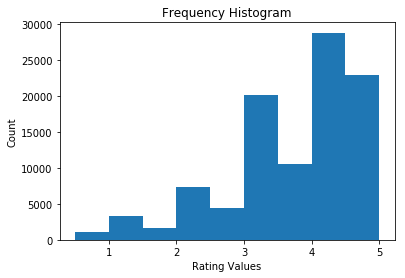

In [6]:
ratings = df['rating']
ratings = list(ratings)
binwidth = 0.5
plt.hist(ratings, bins=np.arange(min(ratings), max(ratings) + binwidth, binwidth))
plt.xlabel('Rating Values')
plt.ylabel('Count')
plt.title('Frequency Histogram')
plt.show()

# 3: Distribution of Ratings among Movies

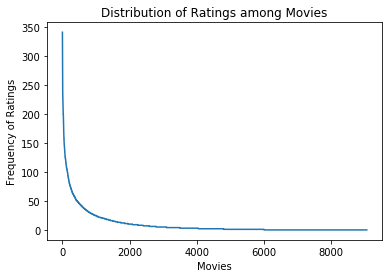

No. of movies are: 9066
3063


In [7]:
movie_distr = df['movieId'].value_counts()
plt.plot(list(movie_distr))
plt.xlabel('Movies')
plt.ylabel('Frequency of Ratings')
plt.title('Distribution of Ratings among Movies')
plt.show()
print('No. of movies are:', len(set(df['movieId'])), sep=' ')
print(len([movie for movie in movie_distr if movie== 1]))
#print(movie_distr)

# 4: Distribution of Ratings among Users

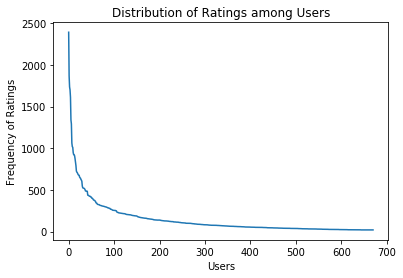

In [8]:
user_distr = df['userId'].value_counts()
plt.plot(list(user_distr))
plt.xlabel('Users')
plt.ylabel('Frequency of Ratings')
plt.title('Distribution of Ratings among Users')
plt.show()

# 5: Explain 3 - Report

# 6: Variance of Rating Values

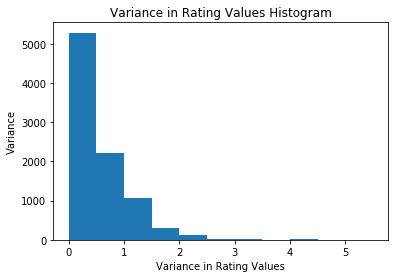

In [9]:
var_rating = df[['movieId', 'rating']].groupby('movieId').var(ddof=0)
var_rating = var_rating.dropna()
var_rating = list(var_rating['rating'])
binwidth = 0.5
plt.hist(var_rating, bins=np.arange(min(var_rating), max(var_rating) + binwidth, binwidth))
plt.xlabel('Variance in Rating Values')
plt.ylabel('Variance')
plt.title('Variance in Rating Values Histogram')
plt.show()

# 7: Formula for Uu in terms of Iu and ruk

In [10]:
%%latex
\[ \mu_u  = \frac{\sum_{k \epsilon I_u} r_{uk}}{\sum I_{u}} \]

<IPython.core.display.Latex object>

# 8: Explain
### Iu intersection Iv :- This means we are trying to find the set of items that both the users u and v have rated.
### Can Iu intersection Iv = nullset :- Yes, it can!
### Iu intersection Iv = nullset :- If the set of items that both the users have rated is empty, it means that the users u and v have no items common to each other. This also indicates that the users u and v are very unlikely to be neighbours.

# 9:Explain
### //TODO

# 10:Design a k-NN collaborative filter to predict the ratings of the movies

In [11]:
def plot_rmse_mae(val):
    mean_rmse = []
    mean_mae = []
    for i in range(len(val)):
        mean_rmse.append(sum(val[i]['test_rmse'])/len(val[i]['test_rmse']))
        mean_mae.append(sum(val[i]['test_mae'])/len(val[i]['test_mae']))

    plt.figure(figsize=(20,10))
    plt.plot(range(2,len(val)*2 + 1,2), mean_rmse)

    plt.xlabel('k values')
    plt.ylabel('Average RMSE')
    plt.title('Average RMSE against k values')
    plt.show()

    plt.figure(figsize=(20,10))
    plt.plot(range(2,len(val)*2 + 1,2), mean_mae)

    plt.xlabel('k values')
    plt.ylabel('Average MAE')
    plt.title('Average MAE against k values')
    plt.show()
    return mean_rmse, mean_mae

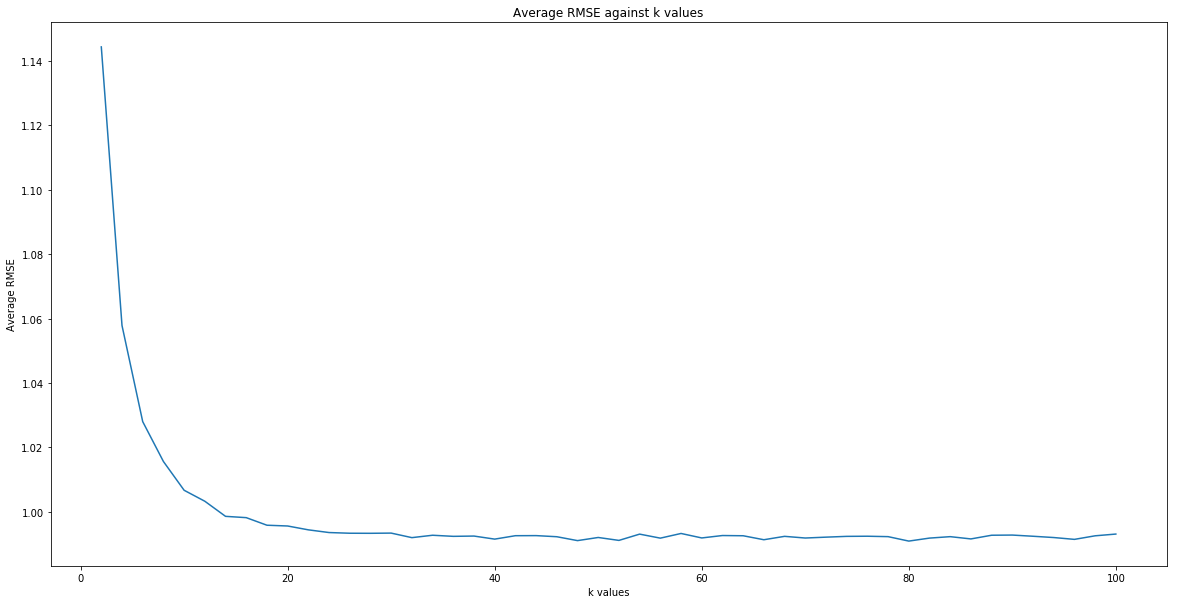

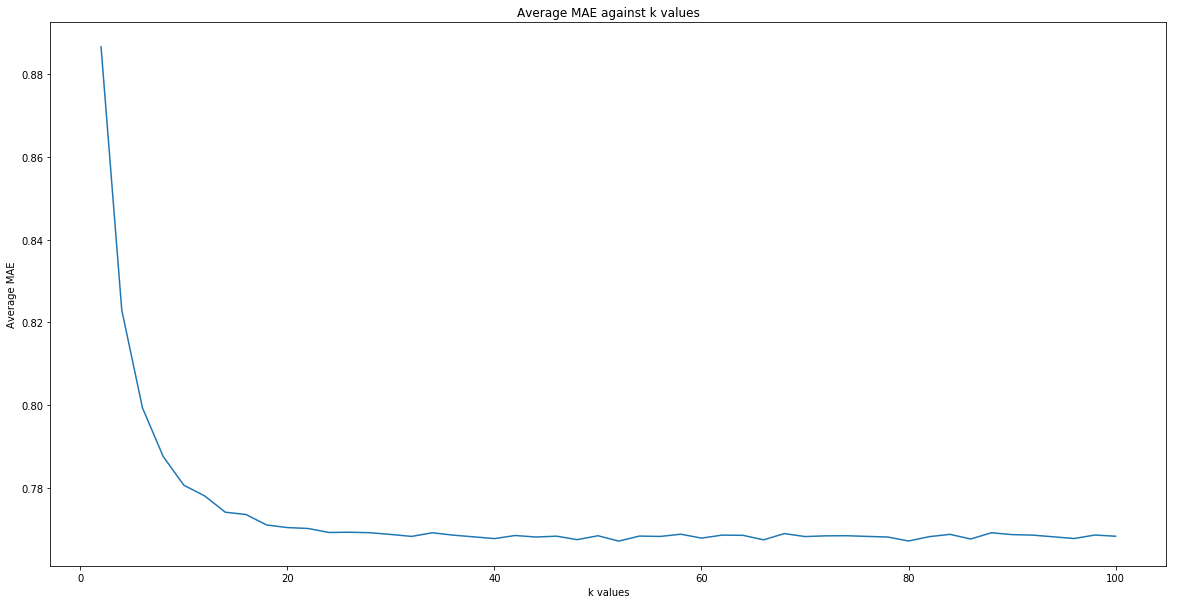

In [12]:
load_model = True
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

if not load_model:
    sim_options = {'name': 'pearson',
                   'user_based': True  # compute  similarities between items
                   }
    list_k = range(2,101, 2)
    print(list(list_k))
    val = []
    for k in list_k:
        model = knns.KNNBasic(k=k, min_k=1, sim_options=sim_options)
        val.append(cross_validate(model, data, measures=['RMSE', 'MAE'], cv=10, verbose=False))

    #Dump the results to knnFull.pkl
    with open('models/knnFull.pkl','wb') as f:
        pickle.dump(val,f)
else:
    val = pickle.load(open('models/knnFull.pkl','rb'))

mean_rmse, mean_mae = plot_rmse_mae(val)

# 11: Find minimum k

In [13]:
diff_mean_rmse = [sum([mean_rmse[i]-k for k in mean_rmse[i:]]) for i in range(len(mean_rmse))]
# plt.plot(range(2,101,2), diff_mean_rmse)
# plt.xlabel('k values')
# plt.ylabel('diff Average RMSE')
# plt.title('diff Average RMSE against k values')
# plt.show()
print('minimum k with RMSE=', 2*mean_rmse.index(mean_rmse[diff_mean_rmse.index(min(diff_mean_rmse))])+2)

minimum k with RMSE= 48


In [14]:
diff_mean_mae = [sum([mean_mae[i]-k for k in mean_mae[i:]]) for i in range(len(mean_mae))]
# plt.plot(range(2,101,2), diff_mean_mae)
# plt.xlabel('k values')
# plt.ylabel('diff Average MAE')
# plt.title('diff Average MAE against k values')
# plt.show()
print('minimum k with MAE=', 2*mean_mae.index(mean_mae[diff_mean_mae.index(min(diff_mean_mae))])+2)

minimum k with MAE= 52


### Hence, we can conclude that k=48 is a good convergence point for both MAE and RMSE.

In [15]:
# RMSE and MAE with k = 48
min_k = 2*mean_rmse.index(mean_rmse[diff_mean_rmse.index(min(diff_mean_rmse))])+2
print('Average RMSE for minimum k(', min_k, ') is:', mean_rmse[min_k//2], 
      'Average MAE for minimum k(', min_k, ') is:', mean_mae[min_k//2])

Average RMSE for minimum k( 48 ) is: 0.9920527987540382 Average MAE for minimum k( 48 ) is: 0.7684647079132884


# Methods to trim the dataset into the popular, unpopular and high variance groups

In [16]:
#Function to trim to dataset to only the popular movies
def trim_popular(testset, counts):
    res = []
    for test in testset:
        if counts[test[1]] > 2:
            res.append(test)
    return res

#function to trim the dataset to only the unpopular movies
def trim_unpopular(testset, counts):
    res = []
    for test in testset:
        if counts[test[1]] <= 2:
            res.append(test)
    return res

#function to trim the dataset to popular movies with a high rating variance
def trim_highVar(testset, counts, variance):
    res = []
    for test in testset:
        if counts[test[1]] >=5 and variance[test[1]] >=2:
            res.append(test)
    return res

#Frequency dictionary based on movieID
def dataset_frequency():
    dataset = get_full_testset()
    counts = Counter(data[1] for data in dataset)
    return counts

#Rating variance based on movieID
def dataset_variance():
    counts = dataset_frequency()
    variance = {}
    dataset = get_full_testset()
    for movieId in counts.keys():
        minRating = 10
        maxRating = -1
        for data in dataset:
            if data[1] == movieId:
                if data[2] > maxRating:
                    maxRating = data[2]
                elif data[2] < minRating:
                    minRating = data[2]
        variance[movieId] = maxRating - minRating
    return variance

#Take the full dataset and convert it to a testset (all data in the form of tuples [(userid,movieid,rating)...])
def get_full_testset():
    reader = Reader(rating_scale=(1, 5))
    dataset = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
    dataset = dataset.build_full_trainset().build_testset()
    return dataset

# 12,13,14: Training the K-NN collaborative filter and testing on 3 trimmed datasets

In [17]:
load_models = True
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

if not load_models:
    
    sim_options = {'name': 'pearson',
                   'user_based': True  # compute  similarities between items
                   }
    kf = KFold(n_splits = 10)

    list_k = range(2,101, 2)
    print(list(list_k))

    val_popular = []
    val_unpopular = []
    val_highVar = []

    counts = dataset_frequency()
    variance = dataset_variance()
    
    for k in list_k:
        model = knns.KNNBasic(k=k, min_k=1, sim_options=sim_options)
    
        valFold_popular = []
        valFold_unpopular = []
        valFold_highVar = []
        for trainset, testset in kf.split(data):
            model.fit(trainset)
            #Get the trimmed testet
            popular_trimmed_testset = trim_popular(testset,counts)
            unpopular_trimmed_testset = trim_unpopular(testset,counts)
            highVariance_testset = trim_highVar(testset,counts,variance)
        
            predictions_popular = model.test(popular_trimmed_testset)
            predictions_unpopular = model.test(unpopular_trimmed_testset)
            predictions_highVar = model.test(highVariance_testset)
        
            valFold_popular.append([accuracy.rmse(predictions_popular,verbose = False),
                                    accuracy.mae(predictions_popular,verbose = False)])
            valFold_unpopular.append([accuracy.rmse(predictions_unpopular,verbose = False),
                                      accuracy.mae(predictions_unpopular,verbose = False)])
            valFold_highVar.append([accuracy.rmse(predictions_highVar,verbose = False),
                                    accuracy.mae(predictions_highVar,verbose = False)])
        
        val_popular.append(valFold_popular)
        val_unpopular.append(valFold_unpopular)
        val_highVar.append(valFold_highVar)

    #Dump the results
    with open('models/knnTrimPopular.pkl','wb') as f:
        pickle.dump(val_popular,f)
    
    with open('models/knnTrimUnpopular.pkl','wb') as f:
        pickle.dump(val_unpopular,f)
    
    with open('models/knnTrimHighVar.pkl','wb') as f:
        pickle.dump(val_highVar,f)
        
else:
    val_popular = pickle.load(open('models/knnTrimPopular.pkl','rb'))
    val_unpopular = pickle.load(open('models/knnTrimUnpopular.pkl','rb'))
    val_highVar = pickle.load(open('models/knnTrimHighVar.pkl','rb'))

# 12: RMSE results for the popular trimmed dataset with K-NN collaborative filter

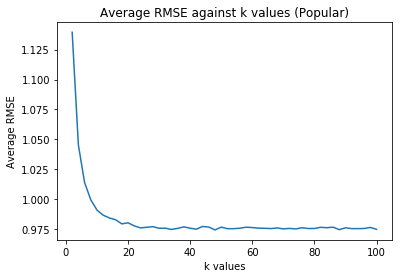


 Minimum Average RMSE is: 0.9743907478134


In [18]:
mean_rmse = []
mean_mae = []
for i in range(len(val_popular)):
    npArr = np.array(val_popular[i])
    mean_rmse.append(sum(npArr[:,0])/len(npArr[:,0]))
    mean_mae.append(sum(npArr[:,1])/len(npArr[:,1]))

plt.plot(range(2,101,2), mean_rmse)
plt.xlabel('k values')
plt.ylabel('Average RMSE')
plt.title('Average RMSE against k values (Popular)')
plt.show()

#Don't need MAE for now
#plt.plot(range(2,101,2), mean_mae)
#plt.xlabel('k values')
#plt.ylabel('Average MAE')
#plt.title('Average MAE against k values (Popular)')
#plt.show()

print('\n Minimum Average RMSE is:', min(mean_rmse))

# 13: RMSE results for the unpopular trimmed dataset with K-NN collaborative filter

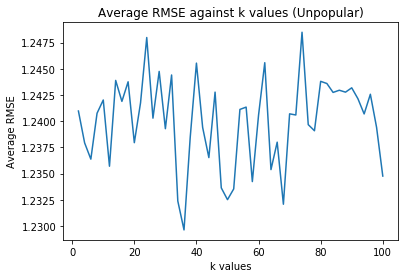


 Minimum Average RMSE is: 1.229630221149743


In [19]:
mean_rmse = []
mean_mae = []
for i in range(len(val_unpopular)):
    npArr = np.array(val_unpopular[i])
    mean_rmse.append(sum(npArr[:,0])/len(npArr[:,0]))
    mean_mae.append(sum(npArr[:,1])/len(npArr[:,1]))

plt.plot(range(2,101,2), mean_rmse)
plt.xlabel('k values')
plt.ylabel('Average RMSE')
plt.title('Average RMSE against k values (Unpopular)')
plt.show()

#Don't need MAE for now
#plt.plot(range(2,101,2), mean_mae)
#plt.xlabel('k values')
#plt.ylabel('Average MAE')
#plt.title('Average MAE against k values (Unpopular)')
#plt.show()

print('\n Minimum Average RMSE is:', min(mean_rmse))

# 14: RMSE results for the high variance trimmed dataset with K-NN collaborative filter

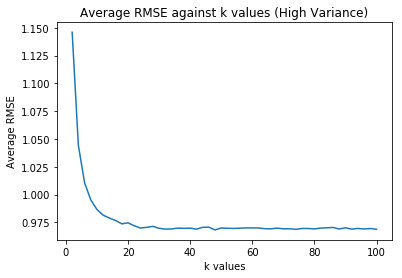


 Minimum Average RMSE is: 0.968206475574596


In [20]:
mean_rmse = []
mean_mae = []
for i in range(len(val_highVar)):
    npArr = np.array(val_highVar[i])
    mean_rmse.append(sum(npArr[:,0])/len(npArr[:,0]))
    mean_mae.append(sum(npArr[:,1])/len(npArr[:,1]))

plt.plot(range(2,101,2), mean_rmse)
plt.xlabel('k values')
plt.ylabel('Average RMSE')
plt.title('Average RMSE against k values (High Variance)')
plt.show()

#Don't need MAE for now
#plt.plot(range(2,101,2), mean_mae)
#plt.xlabel('k values')
#plt.ylabel('Average MAE')
#plt.title('Average MAE against k values (High Variance)')
#plt.show()

print('\n Minimum Average RMSE is:', min(mean_rmse))

# 15: ROC Curve for kNN filter

In [21]:
trainset, testset = train_test_split(data, test_size=.10)
sim_options = {'name': 'pearson',
                   'user_based': True  # compute  similarities between items
              }
model = knns.KNNBasic(k=min_k, min_k=1, sim_options=sim_options, verbose=False)
predictions = model.fit(trainset).test(testset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


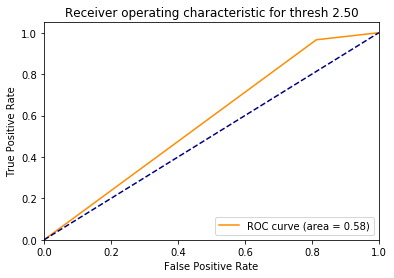

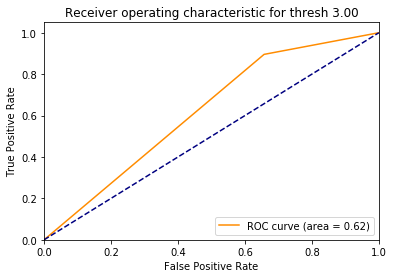

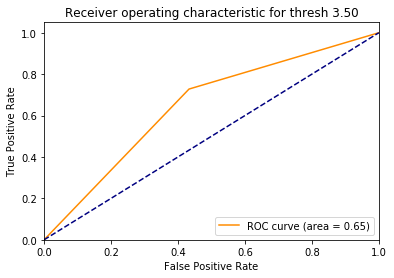

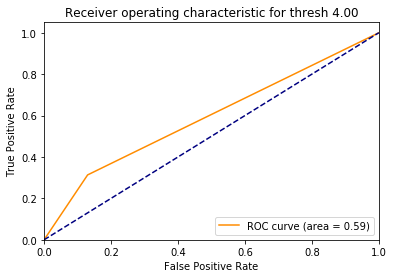

In [22]:
thresholds = [2.5, 3, 3.5, 4]
y_true = [pred[2] for pred in predictions]
y_pred = [pred[3] for pred in predictions]
for thresh in thresholds:
    y_t = list((map(lambda x : 0 if x<thresh else 1,y_true)))
    y_p = list((map(lambda x : 0 if x<thresh else 1,y_pred)))
    fpr, tpr, threshs = roc_curve(y_t, y_p)
    roc_auc = auc(fpr, tpr)    
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for thresh %0.2f' % thresh)
    plt.legend(loc="lower right")
    plt.show()

# 16: Explain some theory - Think about it while making report

# 17: NNMF-based collaborative filter

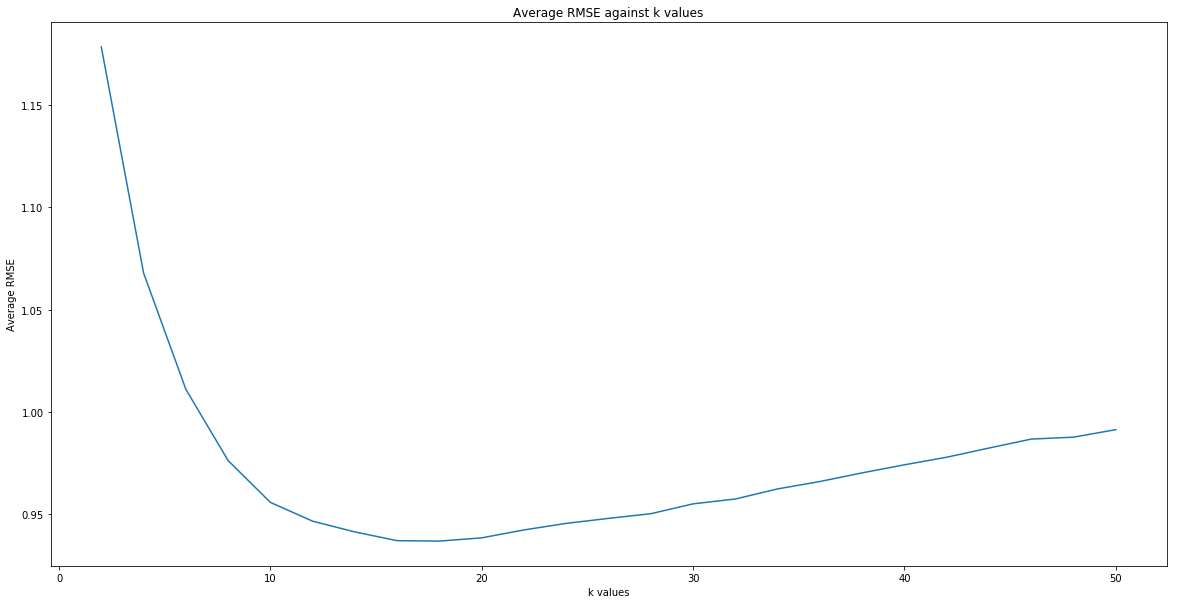

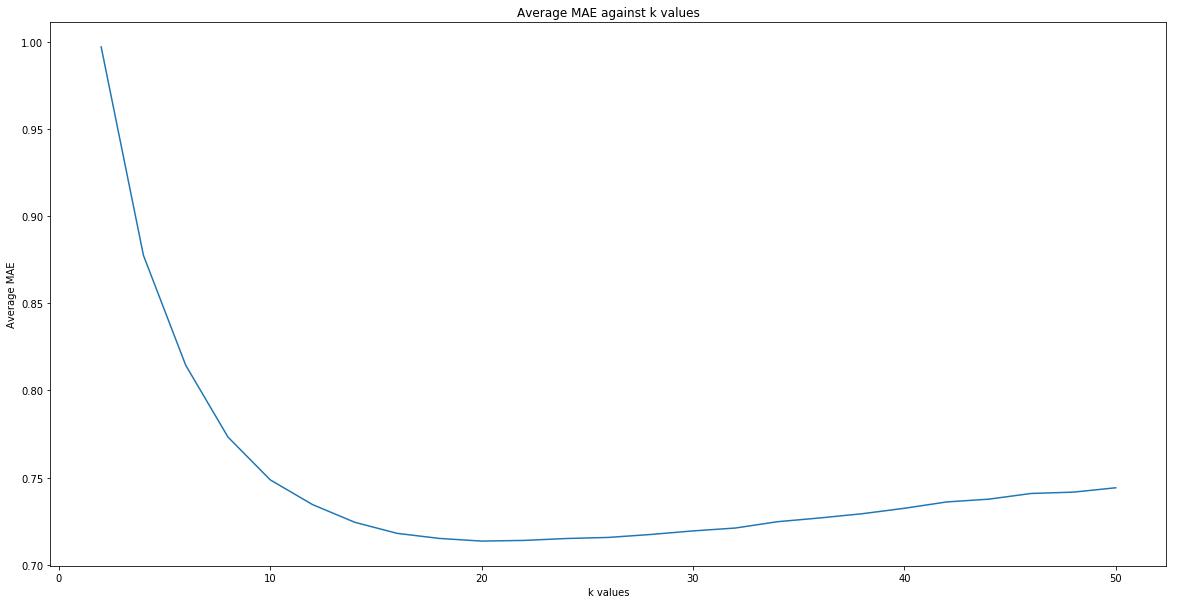

In [23]:
load_model = True
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
latent_factors = list(range(2, 51, 2))
nmf_models = []
if not load_model:
    for lf in latent_factors:
        print(lf)
        nmf_model = matrix_factorization.NMF(n_factors=lf)
        nmf_models.append(cross_validate(nmf_model, data, measures=['RMSE', 'MAE'], cv=10, verbose=False))

    #Dump the results to knnFull.pkl
    with open('models/NNMF_models_full.pkl','wb') as f:
        pickle.dump(nmf_models,f)
else:
    nmf_models = pickle.load(open('models/NNMF_models_full.pkl','rb'))

nmf_mean_rmse, nmf_mean_mae = plot_rmse_mae(nmf_models)

# 18: Optimal number of latent factors

In [24]:
print('Optimal number of latent factors is:', nmf_mean_rmse.index(min(nmf_mean_rmse))*2+2, 
      'or', nmf_mean_mae.index(min(nmf_mean_mae))*2+2)
movies = pd.read_csv('data/ml-latest-small/movies.csv')
movies = movies['genres']
movies = list(movies)
movies = [movie.split('|') for movie in movies]
movies = [m for movie in movies for m in movie]
print('Total movie genres are:', len(set(movies)), sep=" ")

Optimal number of latent factors is: 18 or 20
Total movie genres are: 20


In [25]:
diff_nmf_mean_rmse = [sum([nmf_mean_rmse[i]-k for k in nmf_mean_rmse[i:]]) for i in range(len(nmf_mean_rmse))]
# plt.plot(range(2,101,2), diff_mean_rmse)
# plt.xlabel('k values')
# plt.ylabel('diff Average RMSE')
# plt.title('diff Average RMSE against k values')
# plt.show()
print('minimum LF with RMSE=', 2*nmf_mean_rmse.index(nmf_mean_rmse[diff_nmf_mean_rmse.index(min(diff_nmf_mean_rmse))])+2,
      sep=" ")

minimum LF with RMSE= 18


In [26]:
diff_nmf_mean_mae = [sum([nmf_mean_mae[i]-k for k in nmf_mean_mae[i:]]) for i in range(len(nmf_mean_mae))]
# plt.plot(range(2,101,2), diff_mean_mae)
# plt.xlabel('k values')
# plt.ylabel('diff Average MAE')
# plt.title('diff Average MAE against k values')
# plt.show()
print('minimum LF with MAE=', 2*nmf_mean_mae.index(nmf_mean_mae[diff_nmf_mean_mae.index(min(diff_nmf_mean_mae))])+2)# RMSE and MAE with k = 48
min_l = 2*nmf_mean_rmse.index(nmf_mean_rmse[diff_nmf_mean_rmse.index(min(diff_nmf_mean_rmse))])+2
print('Average RMSE for minimum latent_factors(', min_l, ') is:', nmf_mean_rmse[min_l//2], 
      'Average MAE for minimum latent_factors(', min_l, ') is:', nmf_mean_mae[min_l//2], sep=" ")

minimum LF with MAE= 20
Average RMSE for minimum latent_factors( 18 ) is: 0.9384419206392559 Average MAE for minimum latent_factors( 18 ) is: 0.7134947878590997


In [27]:
min_l = 2*nmf_mean_rmse.index(nmf_mean_rmse[diff_nmf_mean_rmse.index(min(diff_nmf_mean_rmse))])+2
print('Average RMSE for minimum latent_factors(', min_l, ') is:', nmf_mean_rmse[min_l//2], 
      'Average MAE for minimum latent_factors(', min_l, ') is:', nmf_mean_mae[min_l//2], sep=" ")

Average RMSE for minimum latent_factors( 18 ) is: 0.9384419206392559 Average MAE for minimum latent_factors( 18 ) is: 0.7134947878590997


### Hence, the number of latent factors = number of movie genres = 20

# 19, 20, 21: NNMF collaborative filter for popular/unpopular/high variance movies 

In [28]:
load_models = True
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

if not load_models:
    
    kf = KFold(n_splits = 10)

    latent_factors = list(range(2, 51, 2))

    val_popular = []
    val_unpopular = []
    val_highVar = []
    
    counts = dataset_frequency()
    variance = dataset_variance()

    for lf in latent_factors:
        print(lf)
        model = matrix_factorization.NMF(n_factors=lf)
    
        valFold_popular = []
        valFold_unpopular = []
        valFold_highVar = []
        for trainset, testset in kf.split(data):
            model.fit(trainset)
            #Get the trimmed testet
            popular_trimmed_testset = trim_popular(testset,counts)
            unpopular_trimmed_testset = trim_unpopular(testset,counts)
            highVariance_testset = trim_highVar(testset,counts,variance)
        
            predictions_popular = model.test(popular_trimmed_testset)
            predictions_unpopular = model.test(unpopular_trimmed_testset)
            predictions_highVar = model.test(highVariance_testset)
        
            valFold_popular.append([accuracy.rmse(predictions_popular,verbose = False),
                                    accuracy.mae(predictions_popular,verbose = False)])
            valFold_unpopular.append([accuracy.rmse(predictions_unpopular,verbose = False),
                                      accuracy.mae(predictions_unpopular,verbose = False)])
            valFold_highVar.append([accuracy.rmse(predictions_highVar,verbose = False),
                                    accuracy.mae(predictions_highVar,verbose = False)])
        
        val_popular.append(valFold_popular)
        val_unpopular.append(valFold_unpopular)
        val_highVar.append(valFold_highVar)

    #Dump the results
    with open('models/NNMFTrimPopular.pkl','wb') as f:
        pickle.dump(val_popular,f)
    
    with open('models/NNMFTrimUnpopular.pkl','wb') as f:
        pickle.dump(val_unpopular,f)
    
    with open('models/NNMFTrimHighVar.pkl','wb') as f:
        pickle.dump(val_highVar,f)
        
else:
    val_popular = pickle.load(open('models/NNMFTrimPopular.pkl','rb'))
    val_unpopular = pickle.load(open('models/NNMFTrimUnpopular.pkl','rb'))
    val_highVar = pickle.load(open('models/NNMFTrimHighVar.pkl','rb'))

# 19: NNMF Collaborative filter for Popular movies

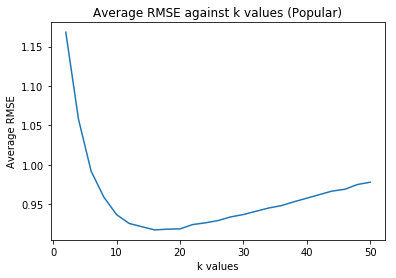


 Minimum Average RMSE is: 0.9171530013875839


In [29]:
mean_rmse = []
mean_mae = []
for i in range(len(val_popular)):
    npArr = np.array(val_popular[i])
    mean_rmse.append(sum(npArr[:,0])/len(npArr[:,0]))
    mean_mae.append(sum(npArr[:,1])/len(npArr[:,1]))

plt.plot(range(2,len(mean_rmse)*2+1,2), mean_rmse)
plt.xlabel('k values')
plt.ylabel('Average RMSE')
plt.title('Average RMSE against k values (Popular)')
plt.show()

#Don't need MAE for now
#plt.plot(range(2,len(mean_rmse)*2+1,2), mean_mae)
#plt.xlabel('k values')
#plt.ylabel('Average MAE')
#plt.title('Average MAE against k values (Popular)')
#plt.show()

print('\n Minimum Average RMSE is:', min(mean_rmse))

# 20: NNMF Collaborative Filter for Unpopular Movies

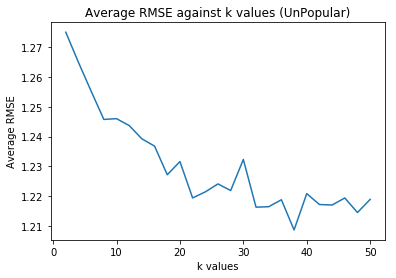


 Minimum Average RMSE is: 1.2086713509470475


In [30]:
mean_rmse = []
mean_mae = []
for i in range(len(val_unpopular)):
    npArr = np.array(val_unpopular[i])
    mean_rmse.append(sum(npArr[:,0])/len(npArr[:,0]))
    mean_mae.append(sum(npArr[:,1])/len(npArr[:,1]))

plt.plot(range(2,len(mean_rmse)*2+1,2), mean_rmse)
plt.xlabel('k values')
plt.ylabel('Average RMSE')
plt.title('Average RMSE against k values (UnPopular)')
plt.show()

#Don't need MAE for now
#plt.plot(range(2,len(mean_rmse)*2+1,2), mean_mae)
#plt.xlabel('k values')
#plt.ylabel('Average MAE')
#plt.title('Average MAE against k values (Popular)')
#plt.show()

print('\n Minimum Average RMSE is:', min(mean_rmse))

# 21: NNMF Collaborative Filter for High Variance Movies

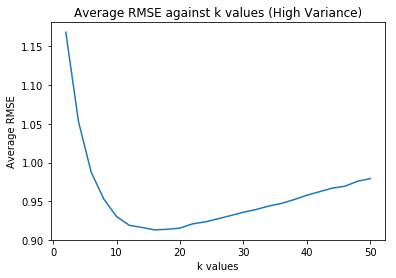


 Minimum Average RMSE is: 0.9129216591177716


In [31]:
mean_rmse = []
mean_mae = []
for i in range(len(val_highVar)):
    npArr = np.array(val_highVar[i])
    mean_rmse.append(sum(npArr[:,0])/len(npArr[:,0]))
    mean_mae.append(sum(npArr[:,1])/len(npArr[:,1]))

plt.plot(range(2,len(mean_rmse)*2+1,2), mean_rmse)
plt.xlabel('k values')
plt.ylabel('Average RMSE')
plt.title('Average RMSE against k values (High Variance)')
plt.show()

#Don't need MAE for now
#plt.plot(range(2,len(mean_rmse)*2+1,2), mean_mae)
#plt.xlabel('k values')
#plt.ylabel('Average MAE')
#plt.title('Average MAE against k values (Popular)')
#plt.show()

print('\n Minimum Average RMSE is:', min(mean_rmse))

# 22: NNMF Collaborative Filter ROC Curve

In [32]:
trainset, testset = train_test_split(data, test_size=.10)
model = matrix_factorization.NMF(n_factors=min_l)
predictions = model.fit(trainset).test(testset)
#print(predictions)

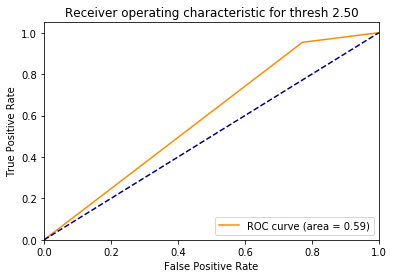

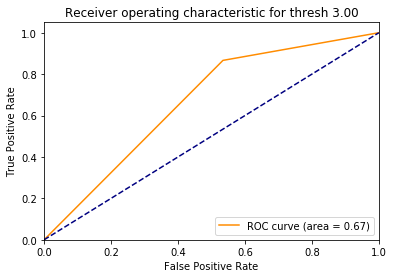

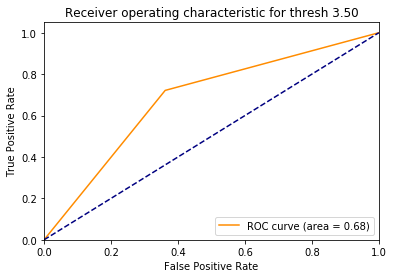

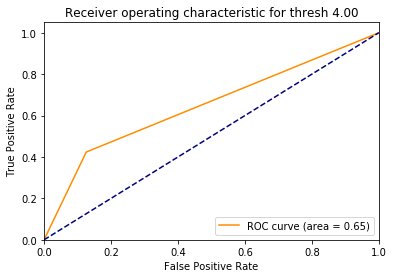

In [33]:
thresholds = [2.5, 3, 3.5, 4]
y_true = [pred[2] for pred in predictions]
y_pred = [pred[3] for pred in predictions]
for thresh in thresholds:
    y_t = list((map(lambda x : 0 if x<thresh else 1,y_true)))
    y_p = list((map(lambda x : 0 if x<thresh else 1,y_pred)))
    fpr, tpr, threshs = roc_curve(y_t, y_p)
    roc_auc = auc(fpr, tpr)    
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for thresh %0.2f' % thresh)
    plt.legend(loc="lower right")
    plt.show()

# 23: NNMF on Ratings

# 24: MF with Bias Collaborative Filter

2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50


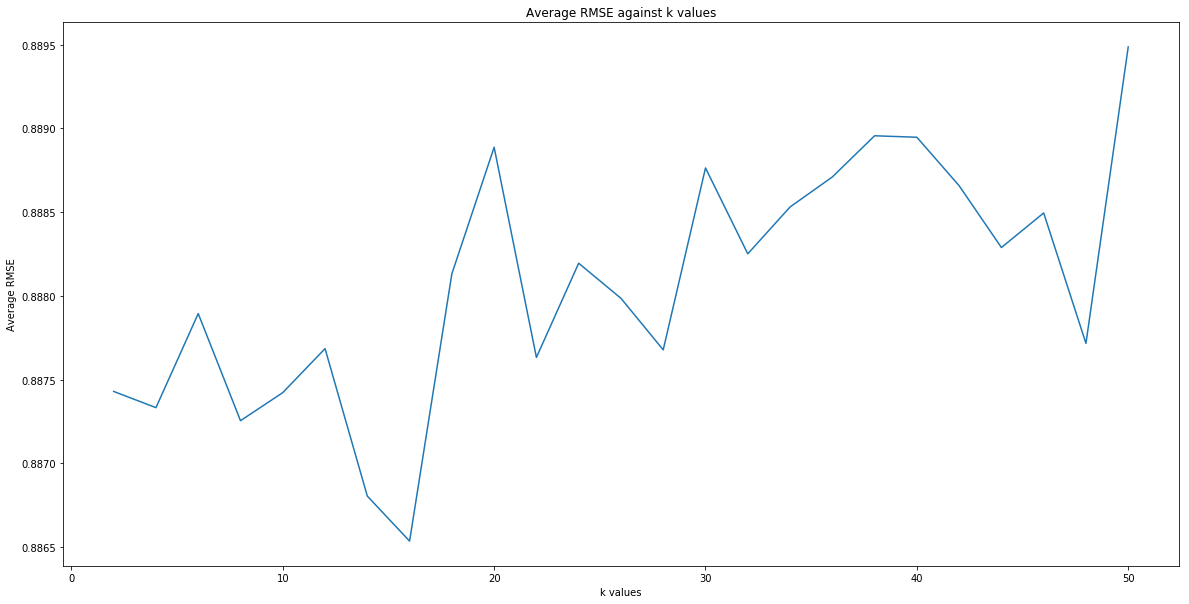

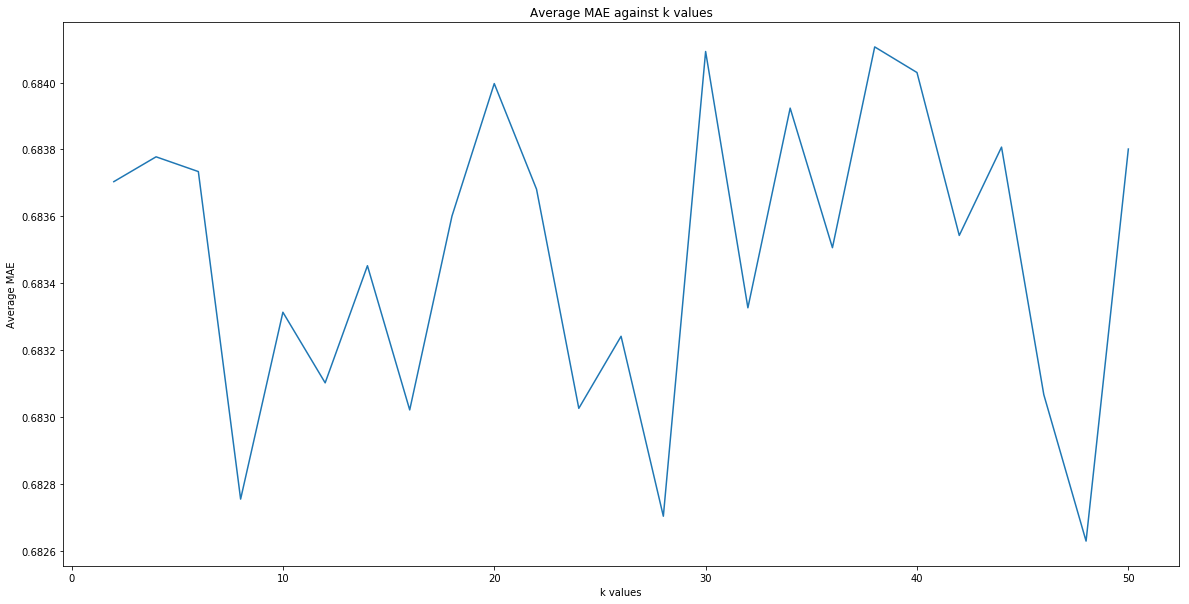

In [35]:
load_model = True
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
latent_factors = list(range(2, 51, 2))
mfb_models = []
if not load_model:
    for lf in latent_factors:
        print(lf)
        mfb_model = matrix_factorization.SVD(n_factors=lf)
        mfb_models.append(cross_validate(mfb_model, data, measures=['RMSE', 'MAE'], cv=10, verbose=False))

    #Dump the results to knnFull.pkl
    with open('models/MFB_models_full.pkl','wb') as f:
        pickle.dump(mfb_models,f)
else:
    mfb_models = pickle.load(open('models/MFB_models_full.pkl','rb'))

mfb_mean_rmse, mfb_mean_mae = plot_rmse_mae(mfb_models)

# 25: Optimal number of latent factors

In [36]:
print('Optimal number of latent factors is:', mfb_mean_rmse.index(min(mfb_mean_rmse))*2+2, 
      'or', mfb_mean_mae.index(min(mfb_mean_mae))*2+2)
movies = pd.read_csv('data/ml-latest-small/movies.csv')
movies = movies['genres']
movies = list(movies)
movies = [movie.split('|') for movie in movies]
movies = [m for movie in movies for m in movie]
print('Total movie genres are:', len(set(movies)))

Optimal number of latent factors is: 16 or 48
Total movie genres are: 20


In [37]:
diff_mfb_mean_rmse = [sum([mfb_mean_rmse[i]-k for k in mfb_mean_rmse[i:]]) for i in range(len(mfb_mean_rmse))]
# plt.plot(range(2,101,2), diff_mean_rmse)
# plt.xlabel('k values')
# plt.ylabel('diff Average RMSE')
# plt.title('diff Average RMSE against k values')
# plt.show()
print('minimum LF with RMSE=', 2*mfb_mean_rmse.index(mfb_mean_rmse[diff_mfb_mean_rmse.index(min(diff_mfb_mean_rmse))])+2)

minimum LF with RMSE= 16


In [38]:
diff_mfb_mean_mae = [sum([mfb_mean_mae[i]-k for k in mfb_mean_mae[i:]]) for i in range(len(mfb_mean_mae))]
# plt.plot(range(2,101,2), diff_mean_mae)
# plt.xlabel('k values')
# plt.ylabel('diff Average MAE')
# plt.title('diff Average MAE against k values')
# plt.show()
print('minimum LF with MAE=', 2*mfb_mean_mae.index(mfb_mean_mae[diff_mfb_mean_mae.index(min(diff_mfb_mean_mae))])+2)# RMSE and MAE with k = 48
min_l = 2*mfb_mean_rmse.index(mfb_mean_rmse[diff_mfb_mean_rmse.index(min(diff_mfb_mean_rmse))])+2
print('Average RMSE for minimum latent_factors(', min_l, ') is:', mfb_mean_rmse[min_l//2], 
      'Average MAE for minimum latent_factors(', min_l, ') is:', mfb_mean_mae[min_l//2])

minimum LF with MAE= 8
Average RMSE for minimum latent_factors( 16 ) is: 0.8881315500122564 Average MAE for minimum latent_factors( 16 ) is: 0.6836008003939162


In [39]:
min_l = 2*mfb_mean_rmse.index(mfb_mean_rmse[diff_mfb_mean_rmse.index(min(diff_mfb_mean_rmse))])+2
print('Average RMSE for minimum latent_factors(', min_l, ') is:', mfb_mean_rmse[min_l//2], 
      'Average MAE for minimum latent_factors(', min_l, ') is:', mfb_mean_mae[min_l//2])

Average RMSE for minimum latent_factors( 16 ) is: 0.8881315500122564 Average MAE for minimum latent_factors( 16 ) is: 0.6836008003939162


# 24, 25, 26: MFB collaborative filter for popular/unpopular/high variance movies

In [47]:
load_models = True
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

if not load_models:
    kf = KFold(n_splits = 10)

    latent_factors = list(range(2, 51, 2))

    val_popular = []
    val_unpopular = []
    val_highVar = []
    
    counts = dataset_frequency()
    variance = dataset_variance()

    for lf in latent_factors:
        print(lf)
        model = matrix_factorization.SVD(n_factors=lf)
    
        valFold_popular = []
        valFold_unpopular = []
        valFold_highVar = []
        for trainset, testset in kf.split(data):
            model.fit(trainset)
            #Get the trimmed testet
            popular_trimmed_testset = trim_popular(testset,counts)
            unpopular_trimmed_testset = trim_unpopular(testset,counts)
            highVariance_testset = trim_highVar(testset,counts,variance)
        
            predictions_popular = model.test(popular_trimmed_testset)
            predictions_unpopular = model.test(unpopular_trimmed_testset)
            predictions_highVar = model.test(highVariance_testset)
        
            valFold_popular.append([accuracy.rmse(predictions_popular,verbose = False),
                                    accuracy.mae(predictions_popular,verbose = False)])
            valFold_unpopular.append([accuracy.rmse(predictions_unpopular,verbose = False),
                                      accuracy.mae(predictions_unpopular,verbose = False)])
            valFold_highVar.append([accuracy.rmse(predictions_highVar,verbose = False),
                                    accuracy.mae(predictions_highVar,verbose = False)])
        
        val_popular.append(valFold_popular)
        val_unpopular.append(valFold_unpopular)
        val_highVar.append(valFold_highVar)

    #Dump the results
    with open('models/MFBTrimPopular.pkl','wb') as f:
        pickle.dump(val_popular,f)
    
    with open('models/MFBTrimUnpopular.pkl','wb') as f:
        pickle.dump(val_unpopular,f)
    
    with open('models/MFBTrimHighVar.pkl','wb') as f:
        pickle.dump(val_highVar,f)
        
else:
    val_popular = pickle.load(open('models/MFBTrimPopular.pkl','rb'))
    val_unpopular = pickle.load(open('models/MFBTrimUnpopular.pkl','rb'))
    val_highVar = pickle.load(open('models/MFBTrimHighVar.pkl','rb'))

# 26: MFB Collaborative filter for Popular movies

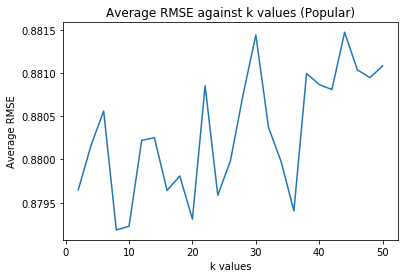


 Minimum Average RMSE is: 0.8791851804015602


In [48]:
mean_rmse = []
mean_mae = []
for i in range(len(val_popular)):
    npArr = np.array(val_popular[i])
    mean_rmse.append(sum(npArr[:,0])/len(npArr[:,0]))
    mean_mae.append(sum(npArr[:,1])/len(npArr[:,1]))

plt.plot(range(2,len(mean_rmse)*2+1,2), mean_rmse)
plt.xlabel('k values')
plt.ylabel('Average RMSE')
plt.title('Average RMSE against k values (Popular)')
plt.show()

#Don't need MAE for now
#plt.plot(range(2,len(mean_rmse)*2+1,2), mean_mae)
#plt.xlabel('k values')
#plt.ylabel('Average MAE')
#plt.title('Average MAE against k values (Popular)')
#plt.show()

print('\n Minimum Average RMSE is:', min(mean_rmse))

# 27: MFB Collaborative Filter for Unpopular Movies

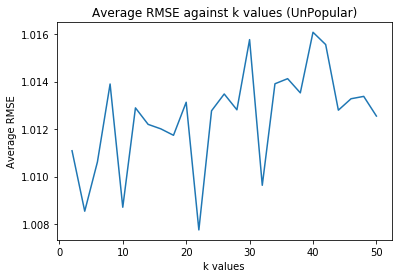


 Minimum Average RMSE is: 1.0077556952285986


In [49]:
mean_rmse = []
mean_mae = []
for i in range(len(val_unpopular)):
    npArr = np.array(val_unpopular[i])
    mean_rmse.append(sum(npArr[:,0])/len(npArr[:,0]))
    mean_mae.append(sum(npArr[:,1])/len(npArr[:,1]))

plt.plot(range(2,len(mean_rmse)*2+1,2), mean_rmse)
plt.xlabel('k values')
plt.ylabel('Average RMSE')
plt.title('Average RMSE against k values (UnPopular)')
plt.show()

#Don't need MAE for now
#plt.plot(range(2,len(mean_rmse)*2+1,2), mean_mae)
#plt.xlabel('k values')
#plt.ylabel('Average MAE')
#plt.title('Average MAE against k values (Popular)')
#plt.show()

print('\n Minimum Average RMSE is:', min(mean_rmse))

# 28: MFB Collaborative Filter for High Variance Movies

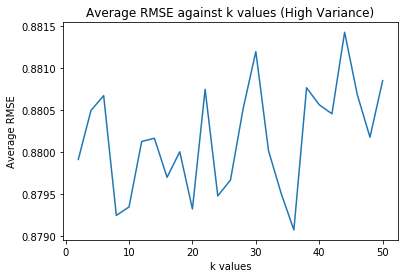


 Minimum Average RMSE is: 0.8790688401572042


In [50]:
mean_rmse = []
mean_mae = []
for i in range(len(val_highVar)):
    npArr = np.array(val_highVar[i])
    mean_rmse.append(sum(npArr[:,0])/len(npArr[:,0]))
    mean_mae.append(sum(npArr[:,1])/len(npArr[:,1]))

plt.plot(range(2,len(mean_rmse)*2+1,2), mean_rmse)
plt.xlabel('k values')
plt.ylabel('Average RMSE')
plt.title('Average RMSE against k values (High Variance)')
plt.show()

#Don't need MAE for now
#plt.plot(range(2,len(mean_rmse)*2+1,2), mean_mae)
#plt.xlabel('k values')
#plt.ylabel('Average MAE')
#plt.title('Average MAE against k values (Popular)')
#plt.show()

print('\n Minimum Average RMSE is:', min(mean_rmse))

# 29: MFB Collaborative Filter ROC Curve

In [51]:
trainset, testset = train_test_split(data, test_size=.10)
model = matrix_factorization.SVD(n_factors=min_l)
predictions = model.fit(trainset).test(testset)
#print(predictions)

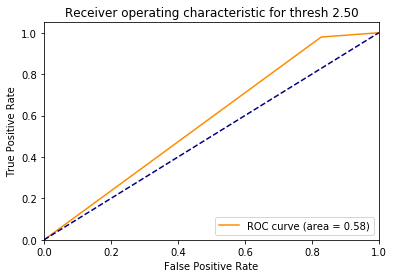

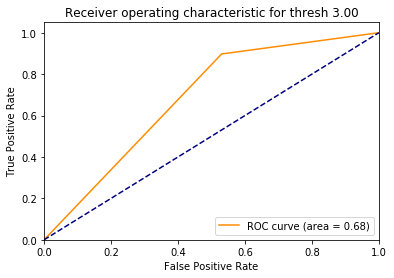

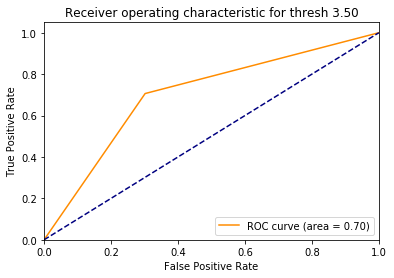

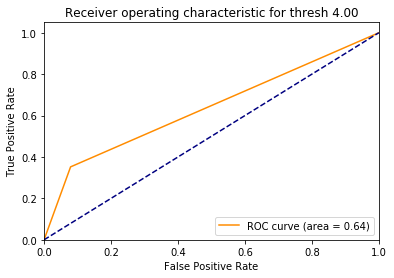

In [52]:
thresholds = [2.5, 3, 3.5, 4]
y_true = [pred[2] for pred in predictions]
y_pred = [pred[3] for pred in predictions]
for thresh in thresholds:
    y_t = list((map(lambda x : 0 if x<thresh else 1,y_true)))
    y_p = list((map(lambda x : 0 if x<thresh else 1,y_pred)))
    fpr, tpr, threshs = roc_curve(y_t, y_p)
    roc_auc = auc(fpr, tpr)    
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for thresh %0.2f' % thresh)
    plt.legend(loc="lower right")
    plt.show()

# 30: Naive collaborative filter

In [53]:
#Might need to change if the mean rating is on the training set instead of the whole dataset
def mean_user_rating():
    mean_rating = df[['userId', 'rating']].groupby('userId').mean()
    return dict(mean_rating['rating'])

def naive_filter_predict(testset):
    mean_user_ratings = mean_user_rating()
    predictions = {}
    predictions['trueValue'] = []
    predictions['predictedValue'] = []
    for test in testset:
            predictions['trueValue'].append(test[2])
            predictions['predictedValue'].append(mean_user_ratings[test[0]])
    return predictions

In [54]:
load_models = True
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

if not load_models:
    
    kf = KFold(n_splits = 10)
    val = []
    
    for trainset, testset in kf.split(data):

        predictions = naive_filter_predict(testset)
        val.append(sqrt(mean_squared_error(predictions['trueValue'],predictions['predictedValue'])))

    #Dump the results
    with open('models/NaiveFull.pkl','wb') as f:
        pickle.dump(val,f)
    
        
else:
    val = pickle.load(open('models/NaiveFull.pkl','rb'))

print('\n The average RMSE is:', sum(val)/len(val))


 The average RMSE is: 0.9554178586618095


# 31, 32, 33: Naive collaborative filter for popular/unpopular/high variance movies 

In [55]:
load_models = True
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

if not load_models:
    
    kf = KFold(n_splits = 10)
    
    val_popular = []
    val_unpopular = []
    val_highVar = []
    
    counts = dataset_frequency()
    variance = dataset_variance()
    
    for trainset, testset in kf.split(data):

        y_true_popular = []
        y_pred_popular = []
        y_true_unpopular = []
        y_pred_unpopular = []
        y_true_highVar = []
        y_pred_highVar = []
        
        popular_trimmed_testset = trim_popular(testset,counts)
        unpopular_trimmed_testset = trim_unpopular(testset,counts)
        highVariance_testset = trim_highVar(testset,counts,variance)
        
        predictions_popular = naive_filter_predict(popular_trimmed_testset)
        predictions_unpopular = naive_filter_predict(unpopular_trimmed_testset)
        predictions_highVar = naive_filter_predict(highVariance_testset)
        
        val_popular.append(sqrt(mean_squared_error(predictions_popular['trueValue'],
                                                   predictions_popular['predictedValue'])))
        val_unpopular.append(sqrt(mean_squared_error(predictions_unpopular['trueValue'],
                                                     predictions_unpopular['predictedValue'])))
        val_highVar.append(sqrt(mean_squared_error(predictions_highVar['trueValue'],
                                                   predictions_highVar['predictedValue'])))



    #Dump the results
    with open('models/NaiveTrimPopular.pkl','wb') as f:
        pickle.dump(val_popular,f)
        
    with open('models/NaiveTrimUnpopular.pkl','wb') as f:
        pickle.dump(val_unpopular,f)
        
    with open('models/NaiveTrimHighVar.pkl','wb') as f:
        pickle.dump(val_highVar,f)
    
        
else:
    val_popular = pickle.load(open('models/NaiveTrimPopular.pkl','rb'))
    val_unpopular = pickle.load(open('models/NaiveTrimUnpopular.pkl','rb'))
    val_highVar = pickle.load(open('models/NaiveTrimHighVar.pkl','rb'))


# 31: Naive collaborative filter for popular movies 

In [56]:
print('\n The average RMSE is:', sum(val_popular)/len(val_popular))


 The average RMSE is: 0.9521310331064244


# 32: Naive collaborative filter for unpopular movies 

In [57]:
print('\n The average RMSE is:', sum(val_unpopular)/len(val_unpopular))


 The average RMSE is: 1.0099509958717203


# 33: Naive collaborative filter for high variance movies 

In [58]:
print('\n The average RMSE is:', sum(val_highVar)/len(val_highVar))


 The average RMSE is: 0.9544591824166053


# 34: Comparing Different Models

In [59]:
#knn Filter
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.10)
sim_options = {'name': 'pearson',
                   'user_based': True  # compute  similarities between items
              }
min_k = 48
model = knns.KNNBasic(k=min_k, min_k=1, sim_options=sim_options, verbose=False)
predictions = model.fit(trainset).test(testset)

min_l = 20
nmf_model = matrix_factorization.NMF(n_factors=min_l)
nmf_predictions = nmf_model.fit(trainset).test(testset)

thresh = 3
y_true = [pred[2] for pred in predictions]
y_pred = [pred[3] for pred in predictions]

nmf_y_true = [pred[2] for pred in nmf_predictions]
nmf_y_pred = [pred[3] for pred in nmf_predictions]

Computing the pearson similarity matrix...
Done computing similarity matrix.


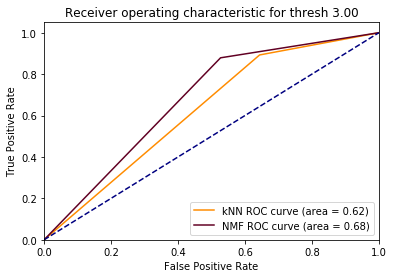

In [60]:
y_t = list((map(lambda x : 0 if x<thresh else 1,y_true)))
y_p = list((map(lambda x : 0 if x<thresh else 1,y_pred)))
fpr, tpr, threshs = roc_curve(y_t, y_p)
roc_auc = auc(fpr, tpr)    
plt.plot(fpr, tpr, color='darkorange',
         label='kNN ROC curve (area = %0.2f)' % roc_auc)

y_t = list((map(lambda x : 0 if x<thresh else 1,nmf_y_true)))
y_p = list((map(lambda x : 0 if x<thresh else 1,nmf_y_pred)))
fpr, tpr, threshs = roc_curve(y_t, y_p)
roc_auc = auc(fpr, tpr)    
plt.plot(fpr, tpr, color='xkcd:burgundy',
         label='NMF ROC curve (area = %0.2f)' % roc_auc)
    
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for thresh %0.2f' % thresh)
plt.legend(loc="lower right")
plt.show()

# 35: Precision and Recall
### Precision: Precision can be defined as the ratio of "number of correctly recalled events from the total number of events recalled"
### Recall: Recall can be defined as the ratio of "total number of correctly recalled events from all correct events".